## ML - Assignment 2: TMDB Box Office Prediction

*Submitted by: <br>
Arja Sivapiragasam, Arisa Seljestokken & Raida Talukdar*

### General information / problem

Skriver problemstillingen vår her

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")
import ast
from collections import Counter
from wordcloud import WordCloud

In [2]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

### Data loading and overview

In [3]:
# a function that reads all the data from a csv
# file to a DataFrame

train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train = train_set.copy()
test = test_set.copy()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

The training set has 23 columns, whereas the test set has only 22 columns because it does not have the revenue column. 

Most of the datatypes are objects and should be converted because the desired datatype is int64.

## Kommentarer:

#### Predict:
    * revenue

#### Disse vil vi fokusere på:
    * budget (Arja), imputer
    * genre (Arja/Raida), multilable binariser
    * popularity, gjøre om til int
    * runtime, gjøre om til int


#### Disse vil vi erstatte:
    * homepage
    * belongs_to_collection
    * og_language
    
    
    
#### Disse vil vi droppe:
    * poster_path
    * imdb_id
    * status
    * overview
    * title
    * crew
    
    
    
#### Disse vil vi undersøke mer:
    * og_title
    * release_date
    * prod_companies, multilabel binariser?, one hot encoding
    * prod_countries (Arja), multilabel binariser?
    * spoken_languages, length of array
    * tagline
    * keywords
    * cast, lengde på array, se på korrelasjonen
 
 

In [6]:
# The columns that are choosen below are objects containing text

#dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
     #           'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# The following function converts text to dictionaries

#def text_to_dict(df):
 #   for column in dict_columns:
     #   df[column] = df[column].apply(lambda x:
      #          {} if pd.isna(x) else ast.literal_eval(x) )
  #  return df

#train = text_to_dict(train)
#test = text_to_dict(test)

In [7]:
# returns the the first n rows of the data

train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [8]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [9]:
train.shape, test.shape

((3000, 23), (4398, 22))

## Analyzing data

We will now look at some of the most significant attributes from the datasets, and use the various types of values to predict the revenue.

In [10]:
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

This list shows the number of missing values for each attribute in descending order.



Because belongs_to_collection and homepage contains the most numbers of missing values, we will use one hot encoding to analyze and decide how much impact these features will have on the revenue. 

These attrbiutes are useful because ......

The training set before we add and remove useful attributes:

In [31]:
train.head()

,id,budget,genres,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Kahaani,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",마린보이,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


#### belongs_to_collection and homepage:

belongs_to_collection tells us which movies are in collections, and homepage tells us which movie has a homepage.

In [11]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [12]:
# train['has_collection'] = train['belongs_to_collection'].apply(lambda x: 0 if x.isnull() == False else 1)

train['has_collection'] = 0
train.loc[train['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

test['has_collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

#test['has_collection'] = test['belongs_to_collection'].apply(lambda x: 0 if x == {} else 1)

In [29]:
train.head()   # skal fjernes

,id,budget,genres,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Kahaani,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",마린보이,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


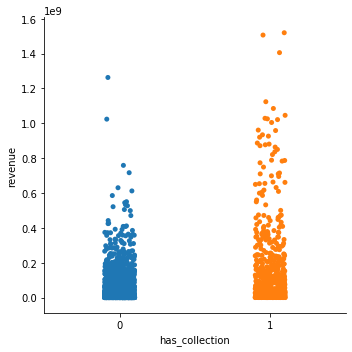

In [14]:
sns.catplot(x="has_collection", y="revenue",data=train)
plt.show()

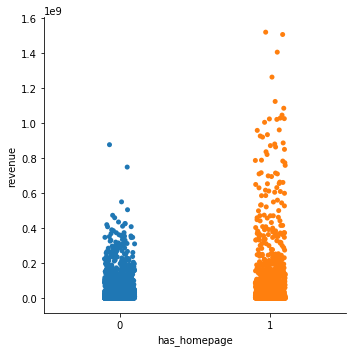

In [15]:
sns.catplot(x="has_homepage", y="revenue",data=train)
plt.show()

The has_collection plot shows that ....

The has_homepage plot shows that ...

We have now made a new attribute has_collection, which means we can drop belongs_to_collection.

We decided to do the same for homepage as well.

In [16]:
train.drop(columns=['belongs_to_collection', 'homepage'], axis =1, inplace=True)
test.drop(columns=['belongs_to_collection', 'homepage'], axis =1, inplace=True)

We have decided to drop the columns poster_path, imdb_id, status, overview, title and crew because we chose to assume they will have no impact on revenue, or because the data is to complex to analyze.

In [17]:
train.drop(columns=['poster_path', 'imdb_id', 'status', 'overview', 'title', 'crew'], axis =1, inplace=True)
test.drop(columns=['poster_path', 'imdb_id', 'status', 'overview', 'title', 'crew'], axis =1, inplace=True)

Let's take a look at the missing values again:

In [28]:
train.isnull().sum().sort_values(ascending=False)

tagline                 597
Keywords                276
production_companies    156
production_countries     55
spoken_languages         20
cast                     13
genres                    7
runtime                   2
budget                    0
original_title            0
popularity                0
og_language               0
release_date              0
has_collection            0
revenue                   0
has_homepage              0
id                        0
dtype: int64

#### original_language:

original_language tells us which original language the movie has. This can be useful because ....

We take a look at the original_language attribute:

In [19]:
train['original_language'].describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

In [20]:
train['original_language']

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

Kommentar: ...

A LabelEncoder can be used to make a new fitting attribute:

In [21]:
encoder = LabelEncoder()
og_language = train['original_language']
og_language_encoded = encoder.fit_transform(og_language)
og_language_encoded

array([7, 7, 7, ..., 7, 7, 7])

In [22]:
encoder.classes_

array(['ar', 'bn', 'cn', 'cs', 'da', 'de', 'el', 'en', 'es', 'fa', 'fi',
       'fr', 'he', 'hi', 'hu', 'id', 'it', 'ja', 'ko', 'ml', 'mr', 'nb',
       'nl', 'no', 'pl', 'pt', 'ro', 'ru', 'sr', 'sv', 'ta', 'te', 'tr',
       'ur', 'vi', 'zh'], dtype=object)

Kommentar: .....

In [23]:
train['og_language'] = og_language_encoded
train.head()  # skal fjernes

,id,budget,genres,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",en,Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",en,Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Kahaani,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,마린보이,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


We can now drop the original_language attribute:

In [24]:
train.drop(columns=['original_language'], axis =1, inplace=True)
test.drop(columns=['original_language'], axis =1, inplace=True)

In [25]:
train.head()  # skal fjernes

,id,budget,genres,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Kahaani,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",마린보이,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


In [26]:
#for i, e in enumerate(train['belongs_to_collection'][:7]):
 #   print(i, e)

In [33]:
# train['belongs_to_collection'].apply(lambda x: len(x)
# if x != {} else 0).value_counts()

Fjernes? :

2396 values in this column are empty, and 604 contain about the collections. The name-collection is perhaps the most useful one.

We can use this next function to see all the missing values in each column in train:

In [35]:
# train.isna().sum()

In [ ]:
#train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

#train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

#train = train.drop(['belongs_to_collection'], axis=1)

# hva kan brukes istedet for len?

#### Genres:

In [ ]:
for i, e in enumerate(train['genres'][:5]):
        print(i, e)

In [ ]:
print('Number of genres in films:')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()


In [ ]:
list_of_genres = list(train['genres'].apply(lambda x: 
[i['name'] for i in x] if x != {} else []).values)


In [ ]:
Counter([i for j in list_of_genres for i in j]).most_common()

#### Production companies:

In [ ]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

In [ ]:
train['production_companies'].apply(lambda x: len(x)
                    if x != {} else 0).value_counts()

In [ ]:
list(train['production_companies'].apply(lambda x: 
[i['name'] for i in x] if x != {} else []).values)

#### Homepage:

In [ ]:
train['homepage'].value_counts().head()

Lists the homepages that are mentioned, and counts the number of each homepage.

#### Spoken languages:

In [ ]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

In [ ]:
print('Number of spoken languages in films:')
train['spoken_languages'].apply(lambda x: len(x)
                        if x != {} else 0).value_counts()

### Data visualization and exploration

#### Plotting budget vs. revenue:

In [ ]:
sns.jointplot(x="budget", y="revenue", data=train,
             height=11, ratio=4, color="pink")
plt.show()

#### Plotting popularity vs. revenue:

In [ ]:
sns.jointplot(x="popularity", y="revenue", data=train,
             height=11, ratio=4, color="purple")
plt.show()

#### Plotting runtime vs. revenue:

In [ ]:
sns.jointplot(x="runtime", y="revenue", data=train,
             height=11, ratio=4, color="green")
plt.show()

#### Revenue (Target Variable) Distribution:

In [ ]:
sns.distplot(train.revenue)

In [ ]:
train.revenue.describe()

Since the revenue-variable is skewed, we are going to 
calculate the log.

In [ ]:
train['logRevenue'] = np.log1p(train['revenue'])
sns.distplot(train['logRevenue'])

#### Calculate release date:

In [ ]:
# the last two digits of the date represents the
# year, so this is a way of getting the release year:

train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)

# some rows have 4 digits of release year insted of 2.
# we can use these conditions to fix that problem: 
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 

train['release_dayofweek'] = releaseDate.dt.dayofweek



#### Plotting the count of release years:

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release Count by Year", fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12, rotation=90)
plt.show()

#### Plotting the count of releases in each month:

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

#### Plotting release day of the week

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

#### Plotting the release year vs. revenue:

In [ ]:
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,6))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

In [ ]:
if False: '''
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
#train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
#plt.xticks(np.arange(1920,2018,6))
#plt.xlabel("Release Year")
#plt.ylabel("Revenue")
#plt.title("Movie Mean Revenue By Year",fontsize=20)

plt.figure(figsize=(20,12))
sns.countplot(train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)

sns.jointplot(data=train, x="Release Year", y="Revenue", title="Movie Mean Revenue By Year",
             height=11, ratio=4, color="pink")

'''

#### Plotting the release month vs. revenue

In [ ]:
train['meanRevenueByMonth'] = train.groupby("release_month")["revenue"].aggregate('mean')
train['meanRevenueByMonth'].plot(figsize=(15,10),color="g")
plt.xlabel("Release Month")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue Release Month",fontsize=20)
plt.show()

#### Movie Mean Popularity by Year:

In [ ]:
train['meanPopularityByYear'] = train.groupby("release_year")["popularity"].aggregate('mean')
train['meanPopularityByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title("Movie Mean Popularity by Year",fontsize=20)
plt.show()

In [ ]:
if False: '''
d1 = train['release_date'].value_counts().sort_index()
d2 = test['release_date'].value_counts().sort_index()

data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
        go.Scatter(x=d2.index, y=d2.values, name='test')]

layout = go.Layout(dict(title = "Number of films per year",
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))
'''